In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from scipy.stats import norm, probplot
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def score_(X_train, X_valid, y_train, y_valid):
    '''
    Score model with Mean Absolute Error
    '''
    model = LinearRegression(n_jobs=5)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mae(y_valid, preds)

In [5]:
df = pd.read_excel('data/dados.xlsx')
df.head()

,address,url,bedrooms,bathrooms,parking,amenities,title,rent,Condomínio,Preço c/ condomínio,IPTU,geocode,suburb,city_district,address_class,postcode,area,type
0,"Avenida Doutor Mário Vilas Boas Rodrigues, 175...",https://www.vivareal.com.br/imovel/apartamento...,2.0,21,1.0,"['Academia', 'Ar-condicionado', 'Churrasqueira...",Apartamento com 2 Quartos e 2 banheiros para...,3900.0,746,4646,225,"Avenida Doutor Mário Vilas Boas Rodrigues, San...",NaN,Santo Amaro,0.0,04757-000,80.0,Aluguel
1,"Rua Fulgêncio Vertello - Cidade Dutra, São Pau...",https://www.vivareal.com.br/imovel/sobrado-1-q...,1.0,1,NaN,[],Sobrado com 1 Quarto e 1 banheiro para Aluga...,900.0,0,0,0,"Rua Fulgêncio Vertello, Cidade Dutra, São Paul...",Cidade Dutra,NaN,0.0,04823-280,40.0,Aluguel
2,"Mirandópolis, São Paulo - SP",https://www.vivareal.com.br/imovel/apartamento...,1.0,1,1.0,"['Academia', 'Churrasqueira', 'Piscina']",Apartamento com 1 Quarto e 1 banheiro para A...,2500.0,726,3226,0,"Mirandópolis, Região Imediata de Andradina, Re...",NaN,NaN,0.0,16800-000,38.0,Aluguel
3,"Rua dos Estudantes, 357 - Sé, São Paulo - SP",https://www.vivareal.com.br/imovel/apartamento...,1.0,11,NaN,"['Academia', 'Aceita animais', 'Bicicletário',...",Apartamento com 1 Quarto e 1 banheiro para A...,1700.0,350,2050,0,"Rua dos Estudantes, Itaim Paulista, São Paulo,...",Itaim Paulista,NaN,0.0,08541-310,27.0,Não informado
4,"Alameda Itu, 78 - Jardins, São Paulo - SP",https://www.vivareal.com.br/imovel/apartamento...,1.0,11,1.0,"['Academia', 'Aceita animais', 'Acesso para de...",Apartamento com 1 Quarto e 1 banheiro para A...,3500.0,706,4206,296,NaN,Jardim Paulista,NaN,NaN,01421-000,45.0,Aluguel


In [4]:
# def get_area_type(row):
#     _v = df2[df2.url == row.url]
#     return _v.loc[_v.index[0], ['area', 'type']]

In [6]:
df['ID'] = df.url.map(lambda x : x.rsplit('-')[-1].replace('/', ''))

In [7]:
#removendo colunas desnecessárias
df.drop(columns=['address', 'amenities', 'title', 'address_class', 'url', 'geocode'], inplace=True)

Quais são os dados nulos?

In [8]:
df.isna().sum().sort_values()

bathrooms                 0
Condomínio                0
Preço c/ condomínio       0
IPTU                      0
type                      0
ID                        0
postcode                188
rent                    260
area                    260
bedrooms                324
suburb                  407
parking                 607
city_district          1031
dtype: int64

In [9]:
def trata_bairro(row):
    '''
    Função para retornar o campo bairro.
    '''
    if pd.isna(row['suburb']) and pd.isna(row['city_district']):
        return np.nan
    if not pd.isna(row['suburb']):
        return row['suburb']
    elif not pd.isna(row['city_district']):
        return row['city_district']
    return 'Analisar'
#     elif row['suburb'] == row['city_district']:
#         return row['city_district']
#     else: 
#         return 'Diferente'

In [10]:
df['bairro'] = df.apply(trata_bairro, axis=1)

Quais os registros sem bairro?

In [11]:
df[df.bairro == 'Analisar']

,bedrooms,bathrooms,parking,rent,Condomínio,Preço c/ condomínio,IPTU,suburb,city_district,postcode,area,type,ID,bairro


In [12]:
df.bairro.isna().sum()

323

Vamos remover os registros que não tenham valores na coluna bairro

In [13]:
df.dropna(subset=['bairro'], inplace=True)

Não precisamos mais das colunas `suburb` e `city_district` e `postcode` (talvez retornemos com o postcode)

In [14]:
df.drop(columns=['suburb', 'city_district', 'postcode'], inplace=True)

O Valor do `aluguel` + `Condomínio` é examtanet o valor do proço total? Sim!!

In [15]:
df=df.drop(columns=['Preço c/ condomínio','IPTU','Condomínio']).rename({
    'bedrooms':'Quartos',
    'bathrooms':'Banheiros',
    'rent':'Preco',
    'bairro':'Bairro',
    'parking': 'Estacionamento'
}, axis=1) #[~((df['rent'].astype(int) + df['Condomínio'].astype(int)) == df['Preço c/ condomínio'].astype(int))]

In [16]:
df.Quartos = df.Quartos.fillna(0).astype(int)

In [17]:
df.Estacionamento = df.Estacionamento.fillna(0)

Valores nulos?

In [18]:
df.isna().sum()

Quartos           0
Banheiros         0
Estacionamento    0
Preco             0
area              0
type              0
ID                0
Bairro            0
dtype: int64

In [19]:
df.reset_index(drop=True, inplace=True)

In [20]:
df.type = df.type.str.strip()

In [25]:
df[df.type == 'Aluguel'].Preco.mean()

33409.75475923852

In [26]:
df[df.type == 'Aluguel'].Preco.median()

2500.0

In [23]:
df.groupby(['type'], as_index=False).ID.count()

,type,ID
0,Aluguel,893
1,Compra,214
2,Não informado,396


In [27]:
df = df[df.type == 'Aluguel']

Removendo os outliers

In [33]:
df= df[df.Preco < 50000].reset_index(drop=True)#.sort_values(by=['Preco'], ascending=False)
df = df[df.Quartos < 6]

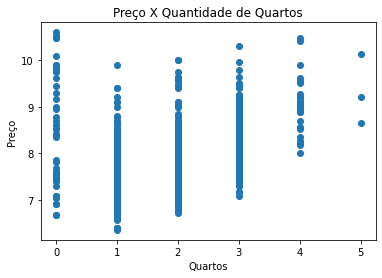

In [34]:
fig, ax= plt.subplots()
ax.scatter(x=df['Quartos'], y=np.log(df['Preco']))
plt.ylabel('Preço')
plt.xlabel('Quartos')
plt.title("Preço X Quantidade de Quartos")
plt.show()

C:\Users\Alexandre\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


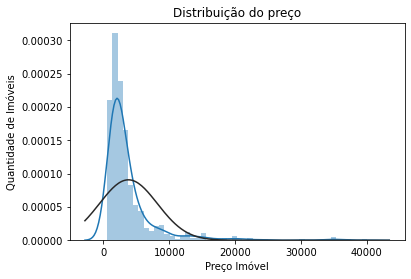

In [35]:
sns.distplot(df.Preco, fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Distribuição do preço')
plt.show()

Vamos ajustar o preço para uma distribuição `normal`

C:\Users\Alexandre\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


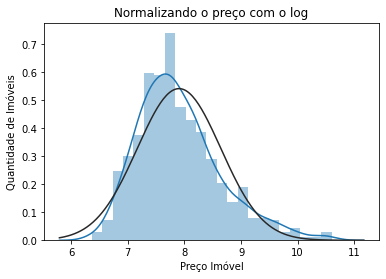

In [36]:
sns.distplot(np.log(df.Preco), fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Normalizando o preço com o log')
plt.show()

In [37]:
df.Preco = np.log(df.Preco)

In [38]:
df.Bairro = df.Bairro.astype("category")

In [39]:
X = df.drop(columns=['Preco', 'type', 'ID'])
y = df['Preco']

In [40]:
# Vamos criar nossa base de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# Vamos criar uma cópia para evitar alterações
label_X_train = X_train.copy()
label_X_test = X_test.copy()

# Vamos aplicar o OrdinarEnconder para a coluna categoria, que no caso é apenas o bairro
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

label_X_train[['Bairro']] = ordinal_encoder.fit_transform(X_train[['Bairro']])
label_X_test[['Bairro']] = ordinal_encoder.transform(X_test[['Bairro']])

print("Mean Absolute Error com OrdinalEnconder:") 
print(score_(label_X_train, label_X_test, y_train, y_test))

Mean Absolute Error com OrdinalEnconder:
0.3738084455458484


In [41]:
scores = cross_val_score(LinearRegression(fit_intercept=False, n_jobs=1, positive=True), label_X_train, y_train, cv=5)
scores

array([-10.89364946, -14.18729023, -15.38429792, -14.16738217,
       -17.43639194])

In [42]:

n_estimators = 5
pipe = Pipeline(steps=[
    #('preprocessor', SimpleImputer()),
    ("normalizacao", MinMaxScaler()),
    ('model', LinearRegression(n_jobs=5))
])
scores = -1 * cross_val_score(pipe, label_X_train, y_train,
                          cv=5,
                          scoring='neg_mean_absolute_error')
scores

array([0.36943809, 0.38601622, 0.37913294, 0.38107659, 0.39503658])

In [43]:
clf = GridSearchCV(LinearRegression(), {'positive': [True, False],'fit_intercept':[True, False], 'n_jobs': [1,3,5,7,10,15,20,30,40,60,100]})
clf.fit(label_X_train, y_train)
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_fit_intercept', 'param_n_jobs', 'param_positive', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [44]:
clf.best_estimator_

LinearRegression(n_jobs=1, positive=True)

In [45]:
clf = GridSearchCV(RandomForestRegressor(), {'n_estimators': [0, 5, 10, 50, 100], 
#                                        'criterion': ["squared_error", "absolute_error", "poisson"],
                                       'max_depth': [0, 4, 7, 10],
#                                        'min_samples_split': [0, 1, 2],
#                                        'min_samples_leaf': [0, 2, 4],
#                                        'bootstrap': [True, False],
                                       'n_jobs': [0, 5, 10],
                                      'max_samples':[0.0, 0.4, 0.6]})
clf.fit(label_X_train, y_train)

C:\Users\Alexandre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
660 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Alexandre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Alexandre\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 389, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "C:\Users\Alexandre\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 121, in _get_n_samples_bootstrap
    raise ValueError(m

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [0, 4, 7, 10],
                         'max_samples': [0.0, 0.4, 0.6],
                         'n_estimators': [0, 5, 10, 50, 100],
                         'n_jobs': [0, 5, 10]})

In [46]:
clf.best_estimator_

RandomForestRegressor(max_depth=10, max_samples=0.4, n_jobs=5)

In [47]:
RandomForestRegressor(max_depth=10, max_samples=0.4, n_jobs=5)

RandomForestRegressor(max_depth=10, max_samples=0.4, n_jobs=5)

In [48]:
n_estimators = 5
pipe = Pipeline(steps=[
    #('preprocessor', SimpleImputer()),
    ("normalizacao", MinMaxScaler()),
    ('model', RandomForestRegressor(max_depth=7, max_samples=0.6, n_jobs=5))
])
scores = -1 * cross_val_score(pipe, label_X_train, y_train,
                          cv=5,
                          scoring='neg_mean_absolute_error')
scores

array([0.34636406, 0.33194   , 0.33266325, 0.34822922, 0.29869638])

In [49]:
n_estimators = 5
pipe = Pipeline(steps=[
    #('preprocessor', SimpleImputer()),
    ("normalizacao", MinMaxScaler()),
    ('model', RandomForestRegressor(max_depth=10, max_samples=0.4, n_jobs=5))
])
scores = -1 * cross_val_score(pipe, label_X_train, y_train,
                          cv=5,
                          scoring='neg_mean_absolute_error')
scores

array([0.339432  , 0.33883108, 0.32857353, 0.34072115, 0.290572  ])

In [50]:
pipe.fit(label_X_test, y_test)

Pipeline(steps=[('normalizacao', MinMaxScaler()),
                ('model',
                 RandomForestRegressor(max_depth=10, max_samples=0.4,
                                       n_jobs=5))])

In [51]:
pipe.score(label_X_test, y_test)

0.8560250248455571

In [52]:
from joblib import dump, load

In [53]:
dump(pipe, 'pipe_rfr.joblib')
dump(ordinal_encoder, 'ordinal_encoder.joblin')

['ordinal_encoder.joblin']

In [54]:
ordinal_encoder = load('ordinal_encoder.joblin')

In [78]:
teste = label_X_train.loc[0,:].to_frame().T

In [79]:
teste

,Quartos,Banheiros,Estacionamento,area,Bairro
0,2.0,21.0,1.0,80.0,96.0


In [80]:
np.exp(pipe.predict(teste))

array([3151.93459626])

In [91]:
teste.loc[0, 'Quartos'] = 1
teste.loc[0, 'Banheiros'] = 1
teste.loc[0, 'Bairro'] = 45
teste.loc[0, 'area'] = 2

In [92]:
teste

,Quartos,Banheiros,Estacionamento,area,Bairro
0,1.0,1.0,1.0,2.0,45.0


In [93]:
np.exp(pipe.predict(teste))

array([1524.2798505])